# Mobile Click Fraud Detection using Spark and Scikit-Learn

### Brian Kim - March 2018


In [202]:
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle 

import requests, os, sys, pyspark,\
            re, math, itertools, warnings,
            patsy

import statsmodels.api as sm
import pylab as pl
import numpy as np

from __future__ import print_function, division


import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
import sklearn.linear_model
from sklearn import preprocessing
from sklearn import feature_selection as f_selectfrom sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV

warnings.filterwarnings('ignore')
pd.options.display.mpl_style = 'default'


In [127]:
pyspark.__version__

'2.1.1+without.hadoop'

## Connect to the Spark server

We will be using the SparkSession (`spark`) to access our spark cluster..

In [128]:
# SparkSession is a conduit to access all spark functionality, 

spark = pyspark.sql.SparkSession.builder.getOrCreate()


## Obtain the data

We begin by reading in our data file.     


When we import the data below, the schema (which is similar to a schema in SQL or dtypes in Pandas) has been inferred based on the data.

In [129]:
##First in pandas
dp=pd.read_pickle('mobile/click_data/dp_pickle.pickle')

In [130]:
dp.columns

Index(['address', 'bankAccount', 'bankaccount', 'partnerid', 'status'], dtype='object')

In [131]:
print (len(dp))
fraud_count = dp.status.value_counts()['Fraud']
fraud_pct = fraud_count/len(dp)
print (fraud_pct)

9145
0.0261344997266


In [132]:
df= pd.read_pickle('mobile/click_data/df_pickle.pickle')

In [133]:
spdf = spark.read.csv('mobile/click_data/df.csv',sep=',',
                     inferSchema=True,
                     header=True)

0.972366412214


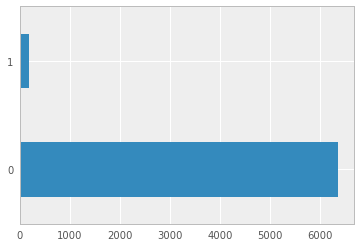

In [195]:
#let's get a count!
fraud_count = dfx.status.value_counts()[0]
fraud_pct = fraud_count/len(dfx)
print (fraud_pct)

dfx['status'].value_counts().plot(kind='barh')
#print(len(dt))

In [ ]:
dp.loc[dp['status']=="Fraud"]

dp.columns

dp.drop(['address', 'bankAccount', 'bankaccount'] ,axis = 1, inplace = True)

df['timeat']= pd.to_datetime(df['timeat'])


dp.columns

df.dtypes

## Feature Engineering 

## Time of Click



In [ ]:
#Calculate per minute features
a= 'avg_per_min'
b ='max_per_min'
c ='var_per_min'
d ='skew_per_min'
e = '60s'
dfonemin =df.groupby(['partnerid', pd.Grouper(key='timeat', freq=e)])\
['partnerid'].count().to_frame(name='onemincount')
dfonem= dfonemin.groupby(['partnerid']).onemincount.agg\
(['mean', 'max', 'var', 'skew'])\
.rename(columns={'mean': a, 'max':b,
'var': c,'skew': d})
dfonem.reset_index(inplace=True)

In [ ]:
#Calculate per five min features
a='avg_per_fivemin'
b='max_per_fivemin'
c='var_per_fivemin'
d='skew_per_fivemin'
e='fivemincount'

dffivemin =df.groupby(['partnerid', pd.Grouper(key='timeat', freq='300s')])\
['partnerid'].count().to_frame(name=e)


dffivemin= dffivemin.groupby(['partnerid']).fivemincount.agg\
(['mean', 'max', 'var', 'skew'])\
.rename(columns={'mean': a, 'max':b,
'var': c,'skew': d})
dffivemin.reset_index(inplace=True)

In [ ]:
#Calculate per hour features
a='avg_per_hour'
b='max_per_hour'
c='var_per_hour'
d='skew_per_hour'
e='onehourcount'
f= '1h'
dfhour =df.groupby(['partnerid', pd.Grouper(key='timeat', freq=f)])\
['partnerid'].count().to_frame(name=e)

dfhour= dfhour.groupby(['partnerid']).onehourcount.agg\
(['mean', 'max', 'var', 'skew'])\
.rename(columns={'mean': a, 'max':b,
'var': c,'skew': d})


dfhour.reset_index(inplace=True)



In [ ]:
#Calculate per 3hour features
a='avg_per_3h'
b='max_per_3h'
c='var_per_3h'
d='skew_per_3h'
e='threehourcount'
f= '3h'
dfthreehour =df.groupby(['partnerid', pd.Grouper(key='timeat', freq=f)])\
['partnerid'].count().to_frame(name=e)

dfthreehour= dfthreehour.groupby(['partnerid']).threehourcount.agg\
(['mean', 'max', 'var', 'skew'])\
.rename(columns={'mean': a, 'max':b,
'var': c,'skew': d})


dfthreehour.reset_index(inplace=True)

In [136]:
#Calculate per six hour features
a='avg_sixhour'
b='max_sixhour'
c='var_sixhour'
d='skew_sixhour'
e='sixhourcount'
f= '6h'
dfsixhour =df.groupby(['partnerid', pd.Grouper(key='timeat', freq=f)])\
['partnerid'].count().to_frame(name=e)

dfsixhour= dfsixhour.groupby(['partnerid']).sixhourcount.agg\
(['mean', 'max', 'var', 'skew'])\
.rename(columns={'mean': a, 'max':b,
'var': c,'skew': d})

dfsixhour.reset_index(inplace=True)

In [137]:
#Merge time features
from functools import reduce

dfs = [dfonem,dffivemin,dfhour,dfthreehour,dfsixhour]
dfx= reduce(lambda left,right: pd.merge(left,right,on='partnerid'), dfs)

In [138]:
dftime =dfx

In [155]:
ip_ct= df.groupby(['partnerid', 'iplong'])['partnerid'].count()

## IP Address Features

In [156]:
## Number of clicks per partner

dfclick = df.groupby(['partnerid']).size().to_frame(name='click_count')

In [159]:
dfclick

,click_count,max_same_ip_ct,ipvar,unq_ip_ct,ip_click_ratio
partnerid,,,,,
8i7t3,1,1,NaN,1,1.000000
8i7u1,1,1,NaN,1,1.000000
8i7uk,93,6,0.442632,76,0.817204
8i7um,1,1,NaN,1,1.000000
8i7ux,762,28,6.602505,391,0.513123
8i7va,9,1,0.000000,9,1.000000
8i7vb,12,2,0.177778,10,0.833333
8i7vf,3,2,0.500000,2,0.666667
8i7vp,4001,267,636.795617,449,0.112222


In [158]:
##count the number of clicks for each ip address
ip_ct= df.groupby(['partnerid', 'iplong'])['partnerid'].count()
#get max of that 
dfclick['max_same_ip_ct']= ip_ct.groupby(level=0).max()

#get var of that 
dfclick['ipvar']=ip_ct.groupby(level=0).var()
#count the number of unique ip address.
dfclick['unq_ip_ct']= df.groupby(['partnerid'])['iplong'].nunique()
#count the number of unique ip addressess and divide by number of clicks from that partner
dfclick['ip_click_ratio'] = dfclick['unq_ip_ct']/dfclick['click_count']

In [150]:
df.loc[df['partnerid'] == '8i7uk'].sort_values(by=['iplong'])


,id,iplong,agent,partnerid,cid,cntr,timeat,category,referer
1518876,15746720,456838342,SAMSUNG-GT-E2232,8i7uk,8flxe,in,2012-02-10 10:07:40,mc,NaN
1517802,15744805,456838342,SAMSUNG-GT-E2232,8i7uk,8gahe,in,2012-02-10 10:04:52,mc,0h0mrtn4r4vks8ck
2148890,139146,460009472,Samsung_GT-C3200,8i7uk,8gpp1,in,2012-02-11 01:03:51,mc,0h0mrtn4r4vks8ck
2843834,1185553,620578852,Nokia_2330c,8i7uk,8fj2r,np,2012-02-11 17:12:31,mc,0h0mrtn4r4vks8ck
1744286,16146108,693150411,Nokia_6120,8i7uk,8gfn7,ke,2012-02-10 17:43:00,mc,NaN
1751764,16159042,693150411,Nokia_6120,8i7uk,8k6xj,ke,2012-02-10 17:54:24,mc,NaN
1660162,15997817,697914372,Nokia_5130,8i7uk,8flyt,eg,2012-02-10 15:19:37,mc,3tx478ihlncwscoo
2551917,690542,700319786,Nokia_2690,8i7uk,8jqdf,ng,2012-02-11 08:14:46,mc,1cye3fvcc01wg4g4
2630038,820526,700371264,SonyEricsson_W20,8i7uk,8fiit,ng,2012-02-11 11:23:08,mc,3vzyrmnuqtc0k8gc
2970765,1400428,700371299,Nokia_3110c,8i7uk,8jyvc,ng,2012-02-11 19:56:30,mc,0h0mrtn4r4vks8ck


In [143]:
# dfclick.reset_index(inplace=True)

## Agent

In [160]:
##count the number of clicks for each agent
agent_ct= df.groupby(['partnerid', 'agent'])['partnerid'].count()


#get max of that 
dfclick['max_same_agent_ct']= agent_ct.groupby(level=0).max()
#get var of that 
dfclick['agent_var']=agent_ct.groupby(level=0).var()
#count the number of unique agents.
dfclick['unq_agent_ct']= df.groupby(['partnerid'])['agent'].nunique()
#count the number of unique agents and divide by number of clicks from that partner
dfclick['agent_click_ratio'] = dfclick['unq_agent_ct']/dfclick['click_count']
dfclick

,click_count,max_same_ip_ct,ipvar,unq_ip_ct,ip_click_ratio,max_same_agent_ct,agent_var,unq_agent_ct,agent_click_ratio
partnerid,,,,,,,,,
8i7t3,1,1,NaN,1,1.000000,1.0,NaN,1,1.000000
8i7u1,1,1,NaN,1,1.000000,1.0,NaN,1,1.000000
8i7uk,93,6,0.442632,76,0.817204,7.0,1.486842,57,0.612903
8i7um,1,1,NaN,1,1.000000,1.0,NaN,1,1.000000
8i7ux,762,28,6.602505,391,0.513123,162.0,140.777789,200,0.262467
8i7va,9,1,0.000000,9,1.000000,1.0,0.000000,9,1.000000
8i7vb,12,2,0.177778,10,0.833333,2.0,0.250000,9,0.750000
8i7vf,3,2,0.500000,2,0.666667,2.0,0.500000,2,0.666667
8i7vp,4001,267,636.795617,449,0.112222,386.0,1179.961117,419,0.104724


In [154]:
agent_ct.head(50)

partnerid  agent           
8i7t3      Nokia_2323          1
8i7u1      NOKIAN95_8GB        1
8i7uk      GT-S5570B           1
           Generic             3
           LG_GT505            1
           MAUI                6
           Motorola_Q9         2
           Nokia_2330c         1
           Nokia_2690          4
           Nokia_2700c         1
           Nokia_3110c         1
           Nokia_5130          4
           Nokia_6120          2
           Nokia_6233          2
           Nokia_6263          1
           Nokia_6300          3
           Nokia_6303          1
           Nokia_6500s         1
           Nokia_6680          1
           Nokia_C1-01         2
           Nokia_C2-01         1
           Nokia_C3-00         1
           Nokia_N8            1
           Nokia_N82           1
           Nokia_X2-01         1
           SAMSUNG-GT-C3560    1
           SAMSUNG-GT-E2232    3
           SAMSUNG-GT-E2652    1
           Samsung_C3010       1
           Sams

## Campaign ID


In [161]:
##Campaign ID
##count the number of clicks for each campaign ID
cid_ct= df.groupby(['partnerid', 'cid'])['partnerid'].count()


#get max of that 
dfclick['max_same_cid_ct']= cid_ct.groupby(level=0).max()
#get var of that 
dfclick['cid_var']=cid_ct.groupby(level=0).var()
#count the number of unique campaign ID.
dfclick['unq_cid_ct']= df.groupby(['partnerid'])['cid'].nunique()
#count the number of unique campaign ID and divide by number of clicks from that partner
dfclick['cid_click_ratio'] = dfclick['unq_cid_ct']/dfclick['click_count']
dfclick

,click_count,max_same_ip_ct,ipvar,unq_ip_ct,ip_click_ratio,max_same_agent_ct,agent_var,unq_agent_ct,agent_click_ratio,max_same_cid_ct,cid_var,unq_cid_ct,cid_click_ratio
partnerid,,,,,,,,,,,,,
8i7t3,1,1,NaN,1,1.000000,1.0,NaN,1,1.000000,1,NaN,1,1.000000
8i7u1,1,1,NaN,1,1.000000,1.0,NaN,1,1.000000,1,NaN,1,1.000000
8i7uk,93,6,0.442632,76,0.817204,7.0,1.486842,57,0.612903,5,1.031356,60,0.645161
8i7um,1,1,NaN,1,1.000000,1.0,NaN,1,1.000000,1,NaN,1,1.000000
8i7ux,762,28,6.602505,391,0.513123,162.0,140.777789,200,0.262467,38,32.396924,192,0.251969
8i7va,9,1,0.000000,9,1.000000,1.0,0.000000,9,1.000000,2,0.125000,8,0.888889
8i7vb,12,2,0.177778,10,0.833333,2.0,0.250000,9,0.750000,2,0.090909,11,0.916667
8i7vf,3,2,0.500000,2,0.666667,2.0,0.500000,2,0.666667,1,0.000000,3,1.000000
8i7vp,4001,267,636.795617,449,0.112222,386.0,1179.961117,419,0.104724,275,3796.438223,130,0.032492


## Country

In [162]:
##Country
##count the number of clicks for each country
cntr_ct= df.groupby(['partnerid', 'cntr'])['partnerid'].count()


#get max of that 
dfclick['max_same_cntr_ct']= cntr_ct.groupby(level=0).max()
#get var of that 
dfclick['cntr_var']=cntr_ct.groupby(level=0).var()
#count the number of unique country
dfclick['unq_cntr_ct']= df.groupby(['partnerid'])['cntr'].nunique()
#count the number of unique country and divide by number of clicks from that partner
dfclick['cntr_click_ratio'] = dfclick['unq_cntr_ct']/dfclick['click_count']


,click_count,max_same_ip_ct,ipvar,unq_ip_ct,ip_click_ratio,max_same_agent_ct,agent_var,unq_agent_ct,agent_click_ratio,max_same_cid_ct,cid_var,unq_cid_ct,cid_click_ratio,max_same_cntr_ct,cntr_var,unq_cntr_ct,cntr_click_ratio
partnerid,,,,,,,,,,,,,,,,,
8i7t3,1,1,NaN,1,1.000000,1.0,NaN,1,1.000000,1,NaN,1,1.000000,1.0,NaN,1,1.000000
8i7u1,1,1,NaN,1,1.000000,1.0,NaN,1,1.000000,1,NaN,1,1.000000,1.0,NaN,1,1.000000
8i7uk,93,6,0.442632,76,0.817204,7.0,1.486842,57,0.612903,5,1.031356,60,0.645161,23.0,1.947241e+01,30,0.322581
8i7um,1,1,NaN,1,1.000000,1.0,NaN,1,1.000000,1,NaN,1,1.000000,1.0,NaN,1,1.000000
8i7ux,762,28,6.602505,391,0.513123,162.0,140.777789,200,0.262467,38,32.396924,192,0.251969,307.0,4.975262e+03,26,0.034121
8i7va,9,1,0.000000,9,1.000000,1.0,0.000000,9,1.000000,2,0.125000,8,0.888889,6.0,6.250000e+00,4,0.444444
8i7vb,12,2,0.177778,10,0.833333,2.0,0.250000,9,0.750000,2,0.090909,11,0.916667,9.0,1.900000e+01,3,0.250000
8i7vf,3,2,0.500000,2,0.666667,2.0,0.500000,2,0.666667,1,0.000000,3,1.000000,3.0,NaN,1,0.333333
8i7vp,4001,267,636.795617,449,0.112222,386.0,1179.961117,419,0.104724,275,3796.438223,130,0.032492,2912.0,3.104000e+05,29,0.007248


## Referer

In [163]:
##Referer
#count the number of unique referers
dfclick['unq_referer_ct']= df.groupby(['partnerid'])['referer'].nunique()
#count the number of unique referers and divide by number of clicks from that partner
dfclick['referer_click_ratio'] = dfclick['unq_referer_ct']/dfclick['click_count']

## Merge dataframes

In [167]:
dfclick.reset_index(inplace = True)
dfclick

,partnerid,click_count,max_same_ip_ct,ipvar,unq_ip_ct,ip_click_ratio,max_same_agent_ct,agent_var,unq_agent_ct,agent_click_ratio,max_same_cid_ct,cid_var,unq_cid_ct,cid_click_ratio,max_same_cntr_ct,cntr_var,unq_cntr_ct,cntr_click_ratio,unq_referer_ct,referer_click_ratio
0,8i7t3,1,1,NaN,1,1.000000,1.0,NaN,1,1.000000,1,NaN,1,1.000000,1.0,NaN,1,1.000000,0,0.000000
1,8i7u1,1,1,NaN,1,1.000000,1.0,NaN,1,1.000000,1,NaN,1,1.000000,1.0,NaN,1,1.000000,1,1.000000
2,8i7uk,93,6,0.442632,76,0.817204,7.0,1.486842,57,0.612903,5,1.031356,60,0.645161,23.0,1.947241e+01,30,0.322581,34,0.365591
3,8i7um,1,1,NaN,1,1.000000,1.0,NaN,1,1.000000,1,NaN,1,1.000000,1.0,NaN,1,1.000000,1,1.000000
4,8i7ux,762,28,6.602505,391,0.513123,162.0,140.777789,200,0.262467,38,32.396924,192,0.251969,307.0,4.975262e+03,26,0.034121,259,0.339895
5,8i7va,9,1,0.000000,9,1.000000,1.0,0.000000,9,1.000000,2,0.125000,8,0.888889,6.0,6.250000e+00,4,0.444444,4,0.444444
6,8i7vb,12,2,0.177778,10,0.833333,2.0,0.250000,9,0.750000,2,0.090909,11,0.916667,9.0,1.900000e+01,3,0.250000,3,0.250000
7,8i7vf,3,2,0.500000,2,0.666667,2.0,0.500000,2,0.666667,1,0.000000,3,1.000000,3.0,NaN,1,0.333333,2,0.666667
8,8i7vp,4001,267,636.795617,449,0.112222,386.0,1179.961117,419,0.104724,275,3796.438223,130,0.032492,2912.0,3.104000e+05,29,0.007248,1817,0.454136
9,8i7vq,1923,243,195.405616,594,0.308892,300.0,373.904798,355,0.184607,167,606.180334,170,0.088404,933.0,2.081781e+04,49,0.025481,1053,0.547582


In [165]:
dp =dp.drop_duplicates('partnerid')

In [168]:
dfx =pd.merge(dftime, dfclick, on='partnerid', how='outer')

In [171]:
dfx.shape, dp.shape

((6713, 40), (6713, 2))

In [113]:
dfx.partnerid.is_unique, dp.partnerid.is_unique

(True, True)

In [172]:
dfx = dfx.merge(dp, on='partnerid', how='left')

In [173]:
dfx.shape

(6713, 41)

In [174]:
dfx.fillna(value = 0, inplace =True)

In [198]:
dfx.to_pickle('mobile/click_data/dfx.pickle')

In [199]:
dfx.to_csv('mobile/click_data/dfx.csv')

In [200]:
sd= spark.read.csv('mobile/click_data/dfx.csv',sep=',',
                     inferSchema=True,
                     header=True)

In [183]:
'''
Drop "Observation" and "Observation_New" which are publishers that are
being observed as possibly fraudulent.
'''
dfx =dfx[dfx.status != 'Observation' ]
dfx =dfx[dfx.status != 'Observation_New' ]

In [189]:
##Change strings to ones and zero is status
dfx.replace(to_replace='Fraud', value=1, inplace=True, )
dfx.replace(to_replace='OK', value=0, inplace=True)

In [190]:
dfx

,partnerid,avg_per_min,max_per_min,var_per_min,skew_per_min,avg_per_fivemin,max_per_fivemin,var_per_fivemin,skew_per_fivemin,avg_per_hour,...,cid_var,unq_cid_ct,cid_click_ratio,max_same_cntr_ct,cntr_var,unq_cntr_ct,cntr_click_ratio,unq_referer_ct,referer_click_ratio,status
0,8i7t3,1.000000,1,0.000000,0.000000,1.000000,1,0.000000,0.000000,1.000000,...,0.000000,1,1.000000,1.0,0.000000e+00,1,1.000000,0,0.000000,0
1,8i7u1,1.000000,1,0.000000,0.000000,1.000000,1,0.000000,0.000000,1.000000,...,0.000000,1,1.000000,1.0,0.000000e+00,1,1.000000,1,1.000000,0
2,8i7uk,1.120482,7,0.473112,7.904006,1.207792,7,0.561517,6.379443,2.066667,...,1.031356,60,0.645161,23.0,1.947241e+01,30,0.322581,34,0.365591,0
3,8i7um,1.000000,1,0.000000,0.000000,1.000000,1,0.000000,0.000000,1.000000,...,0.000000,1,1.000000,1.0,0.000000e+00,1,1.000000,1,1.000000,0
4,8i7ux,1.082386,4,0.101311,4.689375,1.387978,6,0.445914,2.131347,5.686567,...,32.396924,192,0.251969,307.0,4.975262e+03,26,0.034121,259,0.339895,0
5,8i7va,1.000000,1,0.000000,0.000000,1.000000,1,0.000000,0.000000,1.000000,...,0.125000,8,0.888889,6.0,6.250000e+00,4,0.444444,4,0.444444,0
6,8i7vb,1.090909,2,0.090909,3.316625,1.090909,2,0.090909,3.316625,1.200000,...,0.090909,11,0.916667,9.0,1.900000e+01,3,0.250000,3,0.250000,0
7,8i7vf,1.500000,2,0.500000,0.000000,1.500000,2,0.500000,0.000000,1.500000,...,0.000000,3,1.000000,3.0,0.000000e+00,1,0.333333,2,0.666667,0
8,8i7vp,3.803232,28,23.686269,2.071509,10.258974,94,346.557439,2.716198,97.585366,...,3796.438223,130,0.032492,2912.0,3.104000e+05,29,0.007248,1817,0.454136,0
9,8i7vq,1.452417,6,0.607711,2.152637,3.321244,14,6.325690,1.351715,26.708333,...,606.180334,170,0.088404,933.0,2.081781e+04,49,0.025481,1053,0.547582,0
